# Getting Started

This notebook walks through steps to get started working with GOES imagery data using the [goespy](https://github.com/spestana/goes-py) and [goes-ortho](https://github.com/spestana/goes-ortho/) modules. They're very much still a work in progress, so please let me know of any errors or issues you encounter. Feel free to fork the repos and make edits and improvements yourself - it would be much appreciated!

---

### Setup and Pre-Processing Steps

**Setup the conda environment and required python packages:**

1. Create a new conda environment from the provided environment file with `conda env create -f environment.yml`
2. Then activate the new environment with `conda activate goesenv`
3. Clone the [goes-ortho](https://github.com/spestana/goes-ortho) repository (this is still under development and rather than installing to our conda environment, we will import the modules individually as needed).

For for details on handling conda environments, see the documentation ["Managing environments"](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).

You may need to install goes-py from source, rather than from the version on pypi (the python package index from which pip will install goes-py). To install goes-py from source, follow the instructions [here](https://github.com/spestana/goes-py).

Verify that these packages have installed by trying to import them such as in the cell below (make sure that the jupyter notebook is using the correct **"goesenv"** kernel).

In [1]:
import sys
import glob
import goespy
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


======================================== goes-py =========================================
 A Python package can be useful to download dataset from goes satellite on AWS  0.2.1v


In [2]:
# add the relative path to our goes-ortho directory so that we can import modules from there
sys.path.append("../../git/goes-ortho")
import goes_ortho

The above packages should have all imported without errors.

---

### Downloading GOES image products

To download GOES image products, we will use the `download-goes.py` script, which wraps around goespy.ABI_Downloader() to help automate batch downloads (of up to one month of data at a time). In a terminal run the script as follows (note that you can run this script while in any  directory as long as you include the full or relative path to download-goes.py):

```
python download-goes.py --bucket <S3-BUCKET> --year <YEAR> --month <MONTH> --days <START DAY> <END DAY> --product <ABI PRODUCT CODE> --channel <ABI CHANNEL> --bounds <MIN_LAT> <MAX_LAT> <MIN_LON> <MAX_LON> --dir <DESTINATION DIRECTORY>
```

* S3 bucket options: `noaa-goes16`, `noaa-goes17`, or `noaa-goes18` (these correspond to three different GOES satellites)
* Product options: See [here](https://github.com/awslabs/open-data-docs/tree/main/docs/noaa/noaa-goes16#about-the-data) for a full list of GOES data products available on AWS. For details on each product, see the documentation [here](https://www.goes-r.gov/products/overview.html).
* Channel: only needed for L1b Radiance products, otherwise it is ignored.
* Bounds: Degrees of latitude and longitude to crop the image to. Positive longitudes are degrees east, positive latitudes are degrees north.

#### Examples:

This will download the GOES-17 ABI Level-2 Cloud Height (CONUS) product (ABI-L2-ACHAC) for June 1-30, 2022. The NetCDF files will be cropped to within latitudes 30 & 50 and longitudes -125 & -105, and saved in /storage/GOES. 

```python download-goes.py --bucket noaa-goes17 --year 2022 --month 6 --days 1 30 --product ABI-L2-ACHAC --channel none --bounds 30 50 -125 -105 --dir /storage/GOES```

We can do the same command with short flag names:

```python download-goes.py -B noaa-goes17 -Y 2022 -M 6 -D 1 30 -p ABI-L2-ACHAC -c none -b 30 50 -125 -105 -d /storage/GOES```

The downloader function creates a directory tree to automatically organize the image files by date and product. We can use glob to find the filepaths to all the files we just downloaded.

In [3]:
filepaths = glob.glob('/storage/GOES/goes17/2022/7/**/ABI-L2-ACHAC/**/*.nc', recursive=True)

filepaths[0:3] # show the first three filepaths

['/storage/GOES/goes17/2022/7/1/ABI-L2-ACHAC/00/OR_ABI-L2-ACHAC-M6_G17_s20221820001177_e20221820003550_c20221820006401.nc',
 '/storage/GOES/goes17/2022/7/1/ABI-L2-ACHAC/00/OR_ABI-L2-ACHAC-M6_G17_s20221820006177_e20221820008550_c20221820012114.nc',
 '/storage/GOES/goes17/2022/7/1/ABI-L2-ACHAC/00/OR_ABI-L2-ACHAC-M6_G17_s20221820011177_e20221820013550_c20221820016263.nc']

---

### Reproject (and orthorectify) GOES image products

When we download GOES image products, they come in the "ABI Fixed Grid" projection, which you can think of as a coordinate system just within the image plane. However we can reproject this into geographic coordinates (latitude and longitude) (this also includes terrain parallax correction, or orthorectification).

We need to import functions from the goes-ortho module, then loop through all the files we just downloaded to reproject each one. Along the way we'll save a new reprojected NetCDF file.

**An API key is required** to download a digital elevation model (DEM) from Opentopography.org. See more details [here](https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets) on how to register and get your API key.

In this example we will use  `demtype='GEDI_L3'` in the goes_ortho.ortho() function. This is a 1 km spatial resolution nearly global digital elevation model (read more [here](https://portal.opentopography.org/raster?opentopoID=OTSDEM.032022.4326.1)).



In [4]:
import goes_ortho 
# we already did this above, just showing it here again since this is where we are using the goes_ortho functions

In [5]:
# these are the input we will need for the goes_ortho.ortho() function
data_vars = ['HT'] # must be a list, but can have just one member like here, we are just selecting the variable 'HT' (cloud height)
bounds = (-130.0, 30, -115.0, 50) # cropping our images again, to slightly smaller bounds
api_key = '585b1d1639bc5ef8a4a5bdea7e45a8d1' # Opentopography.org API key

In [6]:
# I will just run through the first three files for simplicity, rather than looping through all files

for goes_image_path in filepaths[0:3]:
    # make a new filename and filepath to save the resulting reprojected/orthorectified image
    new_goes_filename = '/storage/GOES/orthorectified/Fog2022/' + goes_image_path.split('/')[-1].split('.')[0] + '_o.nc'

    # orthorectify and reproject
    goes_ortho.ortho(goes_image_path, data_vars, bounds, api_key, new_goes_filename, demtype='GEDI_L3', keep_dem=True)

/home/spestana/opt/anaconda3/envs/goesenv/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -tr 30 30 -t_srs '+proj=lonlat +datum=GRS80' temp_GEDI_L3_-130.0_30_-115.0_50_DEM.tif temp_GEDI_L3_-130.0_30_-115.0_50_DEM_proj.tif
/home/spestana/opt/anaconda3/envs/goesenv/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -tr 30 30 -t_srs '+proj=lonlat +datum=GRS80' temp_GEDI_L3_-130.0_30_-115.0_50_DEM.tif temp_GEDI_L3_-130.0_30_-115.0_50_DEM_proj.tif
Usage: gdalwarp [--help-general] [--formats]
    [-s_srs srs_def] [-t_srs srs_def] [-to "NAME=VALUE"]* [-vshift | -novshift]
    [[-s_coord_epoch epoch] | [-t_coord_epoch epoch]]
    [-order n | -tps | -rpc | -geoloc] [-et err_threshold]
    [-refine_gcps tolerance [minimum_gcps]]
    [-te xmin ymin xmax ymax] [-tr xres yres] [-tap] [-ts width height]
    [-ovr level|AUTO|AUTO-n|NONE] [-wo "NAME=VALUE"] [-ot Byte/Int16/...] [-wt Byte/Int16]
    [-srcnodata "value [value...]"] [-dstnodata "value [val

ERROR 1: PROJ: proj_create: Error 1027 (Invalid value for an argument): Unknown value for datum
ERROR 1: Translating source or target SRS failed:
+proj=lonlat +datum=GRS80
Child returned 1



Get inputs: projection information from the ABI radiance product
...done

Opening DEM file...

Create 2D arrays of longitude and latitude from the DEM
...done

For each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)


...done

Create metadata dictionary about this map
...done

Create pixel map dataset
<xarray.Dataset>
Dimensions:         (latitude: 1892, longitude: 1419)
Coordinates:
  * longitude       (longitude) float64 -130.0 -130.0 -130.0 ... -115.0 -115.0
  * latitude        (latitude) float64 50.0 49.99 49.98 ... 30.03 30.01 30.0
    dem_px_angle_x  (latitude, longitude) float64 0.01303 0.01305 ... 0.05563
    dem_px_angle_y  (latitude, longitude) float64 0.127 0.127 ... 0.08541
Data variables:
    elevation       (latitude, longitude) float32 0.0 0.0 0.0 ... 538.8 542.1
Attributes: (12/21)
    longitude_of_projection_origin:       -137.0
    semi_major_axis:                      6378137.0
    semi_minor_axis:                      6356752.31414
    satellite_height:                     42164160.0
    grs80_eccentricity:                   0.0818191910435
    longitude_of_projection_origin_info:  longitude of geostationary satellit...
    ...                                   ...
    dem_ifov_i

ERROR 1: PROJ: proj_create: Error 1027 (Invalid value for an argument): Unknown value for datum
ERROR 1: Translating source or target SRS failed:
+proj=lonlat +datum=GRS80
Child returned 1



Create 2D arrays of longitude and latitude from the DEM
...done

For each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)
...done

Create metadata dictionary about this map
...done

Create pixel map dataset
<xarray.Dataset>
Dimensions:         (latitude: 1892, longitude: 1419)
Coordinates:
  * longitude       (longitude) float64 -130.0 -130.0 -130.0 ... -115.0 -115.0
  * latitude        (latitude) float64 50.0 49.99 49.98 ... 30.03 30.01 30.0
    dem_px_angle_x  (latitude, longitude) float64 0.01303 0.01305 ... 0.05563
    dem_px_angle_y  (latitude, longitude) float64 0.127 0.127 ... 0.08541
Data variables:
    elevation       (latitude, longitude) float32 0.0 0.0 0.0 ... 538.8 542.1
Attributes: (12/21)
    longitude_of_projection_origin:       -137.0
    semi_major_axis:                      6378137.0
    semi_minor_axis:                      6356752.31414
    satellite_height:                     42164160.0
    grs80_eccentricity:                   

ERROR 1: PROJ: proj_create: Error 1027 (Invalid value for an argument): Unknown value for datum
ERROR 1: Translating source or target SRS failed:
+proj=lonlat +datum=GRS80
Child returned 1



Create 2D arrays of longitude and latitude from the DEM
...done

For each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)
...done

Create metadata dictionary about this map
...done

Create pixel map dataset
<xarray.Dataset>
Dimensions:         (latitude: 1892, longitude: 1419)
Coordinates:
  * longitude       (longitude) float64 -130.0 -130.0 -130.0 ... -115.0 -115.0
  * latitude        (latitude) float64 50.0 49.99 49.98 ... 30.03 30.01 30.0
    dem_px_angle_x  (latitude, longitude) float64 0.01303 0.01305 ... 0.05563
    dem_px_angle_y  (latitude, longitude) float64 0.127 0.127 ... 0.08541
Data variables:
    elevation       (latitude, longitude) float32 0.0 0.0 0.0 ... 538.8 542.1
Attributes: (12/21)
    longitude_of_projection_origin:       -137.0
    semi_major_axis:                      6378137.0
    semi_minor_axis:                      6356752.31414
    satellite_height:                     42164160.0
    grs80_eccentricity:                   

Use glob to find one of the images we just created, make some plots:

In [7]:
reprojected_filepaths = glob.glob('/storage/GOES/orthorectified/Fog2022/*ABI-L2-ACHAC*.nc', recursive=True)

Read one of these files in with xarray:

In [8]:
ds = xr.open_dataset(reprojected_filepaths[0])
ds

<xarray.Dataset>
Dimensions:           (latitude: 1892, longitude: 1419)
Coordinates:
  * longitude         (longitude) float64 -130.0 -130.0 -130.0 ... -115.0 -115.0
  * latitude          (latitude) float64 50.0 49.99 49.98 ... 30.03 30.01 30.0
    dem_px_angle_x    (latitude, longitude) float64 ...
    dem_px_angle_y    (latitude, longitude) float64 ...
Data variables:
    elevation         (latitude, longitude) float32 ...
    HT                (latitude, longitude) float32 ...
    abi_fixed_grid_x  (latitude, longitude) float64 ...
    abi_fixed_grid_y  (latitude, longitude) float64 ...
    zone_labels       (latitude, longitude) int64 ...
Attributes: (12/21)
    longitude_of_projection_origin:       -137.0
    semi_major_axis:                      6378137.0
    semi_minor_axis:                      6356752.31414
    satellite_height:                     42164160.0
    grs80_eccentricity:                   0.0818191910435
    longitude_of_projection_origin_info:  longitude of geostationary satellit...
    ...                                   ...
    dem_ifov_info:                        instantaneous field of view (angula...
    dem_px_angle_x_info:                  DEM grid cell X coordinate (east/we...
    dem_px_angle_y_info:                  DEM grid cell Y coordinate (north/s...
    longitude_info:                       longitude from DEM file
    latitude_info:                        latitude from DEM file
    elevation_info:                       elevation from DEM file

Make a plot

Text(0.5, 1.0, 'Cloud Height')

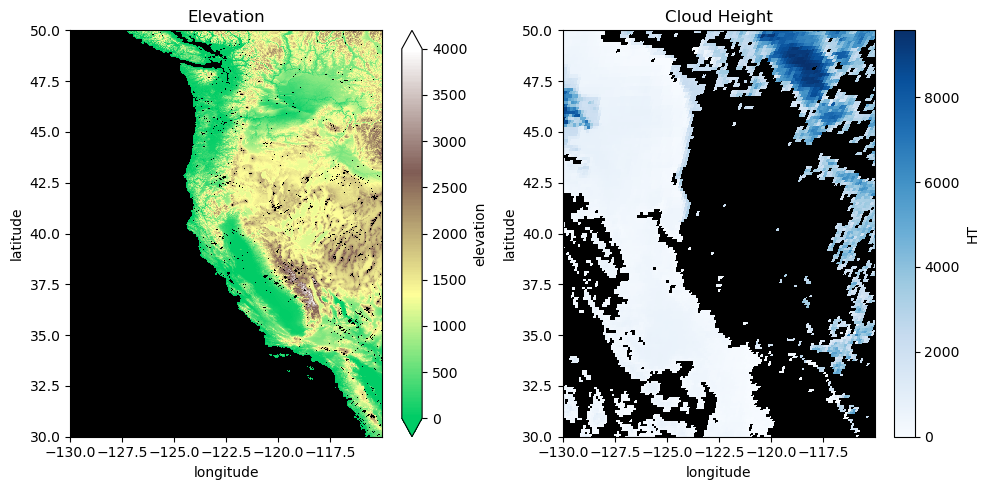

In [9]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,5), tight_layout=True)

ds.elevation.plot(ax=ax1, cmap=matplotlib.colors.LinearSegmentedColormap.from_list('cut_terrain', plt.cm.terrain(np.linspace(0.25, 1, 256))), vmin=0, vmax=4000)
ds.elevation.where(ds.elevation == 0).plot(ax=ax1, cmap='Greys_r', vmin=0, vmax=1000, add_colorbar=False) # plot ocean
ax1.set_title('Elevation')


ds.HT.plot(ax=ax2, cmap='Blues')
ax2.set_facecolor('black')
ax2.set_title('Cloud Height')

In [10]:
#fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6,5), tight_layout=True)
#ds.elevation.plot(ax=ax1, cmap=matplotlib.colors.LinearSegmentedColormap.from_list('cut_terrain', plt.cm.terrain(np.linspace(0.25, 1, 256))), vmin=0, vmax=4000, zorder=-1)
#ds.elevation.where(ds.elevation == 0).plot(ax=ax1, cmap='Greys_r', vmin=0, vmax=1000, add_colorbar=False, zorder=0) # plot ocean
#ds.HT.plot(ax=ax1, cmap='Blues', zorder=1)

---

### Make a timeseries

We can use the goes_timeseries module to extract values from a single point in all the GOES imagery (NetCDF files) we've downloaded as follows:

```
import goes_timeseries

directory = '/storage/GOES/orthorectified/Fog2022/'
product = 'ABI-L2-ACHAC'
data_vars = ['HT']
lon = -123.008
lat = 48.546
elev = 0 # elevation in meters
outfilepath = 'example_timeseries.csv'

df = goes_timeseries.make_abi_timeseries(directory, product, data_vars, lon, lat, elev, outfilepath)
```

In [11]:
import goes_timeseries

In [17]:
directory = '/storage/GOES/goes17/2022/'
product = 'ABI-L2-ACHAC'
data_vars = ['HT']
lon = -123.008
lat = 48.546
elev = 0 # elevation in meters
outfilepath = 'example_timeseries.csv'

In [18]:
df = goes_timeseries.make_abi_timeseries(directory, product, data_vars, lon, lat, elev, outfilepath)

Creating a timeseries of ['HT'] from ABI-L2-ACHAC at (48.546, -123.008, 0)
Reading:
Saving csv file to: example_timeseries.csvC/23/OR_ABI-L2-ACHAC-M6_G17_s20222122356177_e20222122358550_c20222130001378.nc


The function saves a csv file, and returns a pandas dataframe we can take a look at and start plotting right away.

In [19]:
df.head()

,HT
time,
2022-09-01 00:01:17.700,NaN
2022-09-01 00:06:17.700,NaN
2022-09-01 00:11:17.700,1425.301270
2022-09-01 00:16:17.700,2152.601807
2022-09-01 00:21:17.700,2415.687256


(0.0, 11000.0)

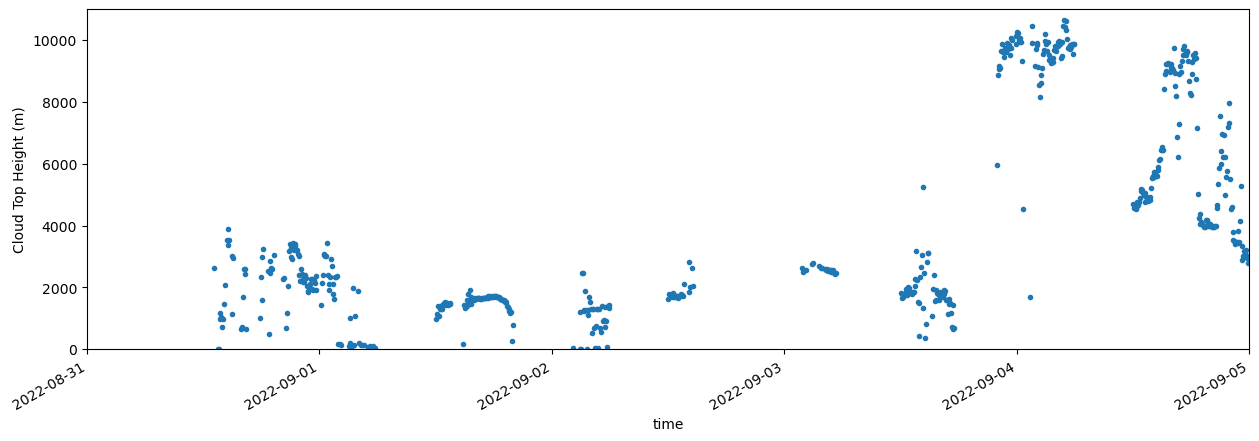

In [34]:
df.HT.plot(linestyle='none', marker='.', figsize=(15,5))
plt.ylabel('Cloud Top Height (m)')
plt.xlim('2022-08-31','2022-09-05')
plt.ylim(0,11000)